# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import json

# Loading the clean dataset

In [2]:
DATASET_PATH = '../data/processed/application_train_cleaned.csv'
# Loading the clean dataset
app_train_df = pd.read_csv(DATASET_PATH)

In [3]:
app_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_ANOMALY,YEARS_BIRTH
0,100002,1,Cash loans,M,0,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,25.920548
1,100003,0,Cash loans,F,0,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,45.931507
2,100004,0,Revolving loans,M,1,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,52.180822
3,100006,0,Cash loans,F,0,Y,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,False,52.068493
4,100007,0,Cash loans,M,0,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,54.608219


In [4]:
print(f"Dataset loaded with {app_train_df.shape[0]} rows and {app_train_df.shape[1]} columns.")
app_train_df.info()

Dataset loaded with 307511 rows and 83 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 83 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   SK_ID_CURR                    307511 non-null  int64  
 1   TARGET                        307511 non-null  int64  
 2   NAME_CONTRACT_TYPE            307511 non-null  object 
 3   CODE_GENDER                   307511 non-null  object 
 4   FLAG_OWN_CAR                  307511 non-null  int64  
 5   FLAG_OWN_REALTY               307511 non-null  object 
 6   CNT_CHILDREN                  307511 non-null  float64
 7   AMT_INCOME_TOTAL              307511 non-null  float64
 8   AMT_CREDIT                    307511 non-null  float64
 9   AMT_ANNUITY                   307511 non-null  float64
 10  AMT_GOODS_PRICE               307511 non-null  float64
 11  NAME_TYPE_SUITE               307511 non-null  object 
 

In [5]:
# Check for missing values
print(app_train_df.isnull().sum().sum())

0


# Encoding Categorical features

In [6]:
categorical_features = app_train_df.select_dtypes(include=['object']).columns.tolist()

# Display summary of categorical features
for feature in categorical_features:
    print(f"--- {feature} ---")
    print(app_train_df[feature].value_counts())
    print("\n")

--- NAME_CONTRACT_TYPE ---
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64


--- CODE_GENDER ---
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


--- FLAG_OWN_REALTY ---
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64


--- NAME_TYPE_SUITE ---
NAME_TYPE_SUITE
Unaccompanied      249818
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64


--- NAME_INCOME_TYPE ---
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


--- NAME_EDUCATION_TYPE ---
NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education        

From this summary we can observe that there is only one ordinal (ordered) feature, that is 'NAME_EDUCATION_TYPE'

In [7]:
# Ordinal feature mapping
# Mapping education levels to numerical values
education_map = {
    'Lower secondary': 0, 
    'Secondary / secondary special': 1, 
    'Incomplete higher': 2, 
    'Higher education': 3, 
    'Academic degree': 4
}

# Apply mapping to the 'NAME_EDUCATION_TYPE' feature
app_train_df['NAME_EDUCATION_TYPE_ENCODED'] = app_train_df['NAME_EDUCATION_TYPE'].map(education_map)
app_train_df.drop(columns=['NAME_EDUCATION_TYPE'], axis=1, inplace=True)

# Update categorical features list
categorical_features.remove('NAME_EDUCATION_TYPE')

All the remaining nominal features can be further categoriesed as low cardinality and high cardinality features

In [8]:
nominal_features = categorical_features.copy()

# Further categorizing nominal features
low_cardinality_features = [feature for feature in nominal_features if app_train_df[feature].nunique() < 10]
high_cardinality_features = [feature for feature in nominal_features if app_train_df[feature].nunique() >= 10]

# Displaying the categorized features
print(f"Low cardinality features: {low_cardinality_features}")
print(f"High cardinality features: {high_cardinality_features}")

Low cardinality features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'EMERGENCYSTATE_MODE']
High cardinality features: ['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']


Low candinality features can be One Hot Encoded using panda's 'get_dummies' method, it is a simple method that is perfect for this stage.

In [9]:
# One Hot Encoding low cardinality features
app_train_df_encoded = pd.get_dummies(app_train_df, columns=low_cardinality_features, drop_first=True)

In [10]:
print(app_train_df_encoded.columns.to_list())

['SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'FLOORSMAX_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOC

For the baseline model, i'll drop the high cardinality features to keep it simple.

In [11]:
# Drop high cardinality features for the baseline model
app_train_df_encoded.drop(columns=high_cardinality_features, axis=1, inplace=True)

Finally, let's drop the 'SK_ID_CURR' column for now, this column will usefull in the future, but for now it's useless

In [12]:
SK_ID_CURR = app_train_df_encoded['SK_ID_CURR']
app_train_df_encoded.drop(columns=['SK_ID_CURR'], axis=1, inplace=True)

In [13]:
print("Shape of the dataframe after encoding:", app_train_df_encoded.shape)
print("Data is now fully encoded and ready for scaling and modeling.")

Shape of the dataframe after encoding: (307511, 105)
Data is now fully encoded and ready for scaling and modeling.


# Baseline Model

Now let's create a baseline model withour any feature creation. I'll later compare ROC-AUC of this model with later models with new features to see if the new features improve performance or not.

In [14]:
X_base = app_train_df_encoded.drop(columns=['TARGET'], axis=1)
y_base = app_train_df_encoded['TARGET']

print(f"Features shape: {X_base.shape}, Target shape: {y_base.shape}")

Features shape: (307511, 104), Target shape: (307511,)


In [15]:
# Splitting the dataset into training and testing sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)

print(f"Training set shape: {X_train_base.shape}, Testing set shape: {X_test_base.shape}")

Training set shape: (246008, 104), Testing set shape: (61503, 104)


In [16]:
# Scaling the features
scaler = MinMaxScaler()
X_train_base_scaled = scaler.fit_transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

print("Features have been scaled using MinMaxScaler.")
print(X_train_base_scaled[:5])  # Display first 5 rows of scaled features

Features have been scaled using MinMaxScaler.
[[0.00000000e+00 1.05263158e-01 5.50120603e-04 4.55730337e-02
  4.51386451e-02 3.47923681e-02 1.09944889e-01 7.28917700e-01
  9.47186244e-01 7.41488327e-01 3.51118522e-01 1.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.57894737e-01 5.00000000e-01 5.00000000e-01
  4.34782609e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.38681666e-01
  6.95038580e-01 9.85100000e-01 3.33300000e-01 9.85100000e-01
  3.33300000e-01 9.85100000e-01 3.33300000e-01 2.19700000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000

In [17]:
# Training a baseline model
baseline_model = LogisticRegression(C=0.0001, random_state=42)
baseline_model.fit(X_train_base_scaled, y_train_base)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.0001
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [18]:
# Evaluating the baseline model
y_pred_proba_baseline = baseline_model.predict_proba(X_test_base_scaled)[:, 1]
roc_auc_baseline = roc_auc_score(y_test_base, y_pred_proba_baseline)

print(f"Baseline model ROC-AUC: {roc_auc_baseline:.4f}")

Baseline model ROC-AUC: 0.6877


# Feature Creation

Time to create some new features and see how they improve the model performance

### Creating New Features

In [19]:
# Domain-specific feature creation
app_train_df_encoded['CREDIT_INCOME_PERCENT'] = app_train_df_encoded['AMT_CREDIT'] / app_train_df_encoded['AMT_INCOME_TOTAL']
app_train_df_encoded['ANNUITY_INCOME_PERCENT'] = app_train_df_encoded['AMT_ANNUITY'] / app_train_df_encoded['AMT_INCOME_TOTAL']
app_train_df_encoded['PAYMENT_RATE'] = app_train_df_encoded['AMT_ANNUITY'] / app_train_df_encoded['AMT_CREDIT']

# Interaction features
app_train_df_encoded['EXT_SOURCE_PRODUCT'] = app_train_df_encoded['EXT_SOURCE_2'] * app_train_df_encoded['EXT_SOURCE_3'] 
# To amplify the interaction effect, we multiply EXT_SOURCE_2 and EXT_SOURCE_3

# Binning continuous features, that are non-linearly related to the target(learned from EDA)
app_train_df_encoded['INCOME_QUANTILE_BINS'] = pd.qcut(app_train_df_encoded['AMT_INCOME_TOTAL'], q=5, labels=False, duplicates='drop')
app_train_df_encoded['CREDIT_QUANTILE_BINS'] = pd.qcut(app_train_df_encoded['AMT_CREDIT'], q=5, labels=False, duplicates='drop')
app_train_df_encoded['ANNUITY_QUANTILE_BINS'] = pd.qcut(app_train_df_encoded['AMT_ANNUITY'], q=5, labels=False, duplicates='drop')
app_train_df_encoded['GOODS_PRICE_QUANTILE_BINS'] = pd.qcut(app_train_df_encoded['AMT_GOODS_PRICE'], q=5, labels=False, duplicates='drop')

print("New features created successfully.")

New features created successfully.


### Splitting the data into train and test set

In [20]:
X_eng1 = app_train_df_encoded.drop(columns=['TARGET'], axis=1)
y_eng1 = app_train_df_encoded['TARGET']

# Splitting the dataset into training and testing sets
X_train_eng1, X_test_eng1, y_train_eng1, y_test_eng1 = train_test_split(X_eng1, y_eng1, test_size=0.2, random_state=42, stratify=y_eng1)

print(f"Training set shape after feature creation: {X_train_eng1.shape}, Testing set shape: {X_test_eng1.shape}")

Training set shape after feature creation: (246008, 112), Testing set shape: (61503, 112)


### Scaling Features

In [21]:
scaler = MinMaxScaler()
X_train_eng1_scaled = scaler.fit_transform(X_train_eng1)  
X_test_eng1_scaled = scaler.transform(X_test_eng1)

print("Features have been scaled using MinMaxScaler.")
print(X_train_eng1_scaled[:5])  # Display first 5 rows of scaled features

Features have been scaled using MinMaxScaler.
[[0.00000000e+00 1.05263158e-01 5.50120603e-04 4.55730337e-02
  4.51386451e-02 3.47923681e-02 1.09944889e-01 7.28917700e-01
  9.47186244e-01 7.41488327e-01 3.51118522e-01 1.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 1.57894737e-01 5.00000000e-01 5.00000000e-01
  4.34782609e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.38681666e-01
  6.95038580e-01 9.85100000e-01 3.33300000e-01 9.85100000e-01
  3.33300000e-01 9.85100000e-01 3.33300000e-01 2.19700000e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000

### Training and Evaluating new model

In [22]:
# Training the model with engineered features
enginered_baseline_model1 = LogisticRegression(C=0.0001, random_state=42)
enginered_baseline_model1.fit(X_train_eng1_scaled, y_train_eng1)

# Evaluating the model with engineered features
y_pred_proba_enginered1 = enginered_baseline_model1.predict_proba(X_test_eng1_scaled)[:, 1]
roc_auc_enginered1 = roc_auc_score(y_test_eng1, y_pred_proba_enginered1)

print(f"Engineered baseline model ROC-AUC: {roc_auc_enginered1:.4f}")

Engineered baseline model ROC-AUC: 0.7034


The baseline model achieved an AUC of 0.6874, while the model with the new, engineered features achieved an AUC of 0.7037. This improvement is a direct result of creating more informative features (like the financial ratios and interaction terms) that allowed the model to better distinguish between defaulters and non-defaulters.

Even though the model performance was improved, let's try and squeeze out even more performance from a simple model. Let's try log transform on skewed features and try a different scaling method

### Train-Test Split

In [23]:
X_eng2 = app_train_df_encoded.drop(columns=['TARGET'], axis=1)
y_eng2 = app_train_df_encoded['TARGET']

X_train_eng2, X_test_eng2, y_train_eng2, y_test_eng2 = train_test_split(X_eng2, y_eng2, test_size=0.2, random_state=42, stratify=y_eng2)

print(f"Training set shape after log transformation: {X_train_eng2.shape}, Testing set shape: {X_test_eng2.shape}")

Training set shape after log transformation: (246008, 112), Testing set shape: (61503, 112)


### PowerTransformer to handle skewness and non-normality

In [24]:
power_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X_train_eng2 = power_scaler.fit_transform(X_train_eng2)
X_test_eng2 = power_scaler.transform(X_test_eng2)

### Scaling with StandardScaler

In [25]:
scaler = StandardScaler()
X_train_eng2_scaled = scaler.fit_transform(X_train_eng2)
X_test_eng2_scaled = scaler.transform(X_test_eng2)

print("Features have been scaled using StandardScaler.")
print(X_train_eng2_scaled[:5])  # Display first 5 rows of scaled features

Features have been scaled using StandardScaler.
[[-7.17397871e-01  1.65623860e+00 -1.03055667e+00 -1.03864580e+00
  -1.06754673e+00 -1.19007339e+00 -1.08375446e+00  8.34942230e-01
   5.63683768e-01 -5.39624256e-01 -1.09590138e+00  2.01616591e-03
   4.67698898e-01 -4.99500728e-01  4.33765049e-02 -6.25066844e-01
  -2.45247346e-01  1.74476344e+00 -9.78181778e-02 -6.16738905e-02
  -6.33202540e-01 -1.23486324e-01 -2.32186306e-01 -2.07223329e-01
  -2.90647870e-01 -5.48148500e-01 -4.69092537e-01 -1.23118431e+00
   5.76640625e-01  5.42167816e-01  1.42115126e+00  5.58647667e-01
   1.43964001e+00  5.40539515e-01  1.42237313e+00  1.93624187e+00
  -8.89829635e-01 -3.59165879e-01 -8.86282491e-01 -3.01746602e-01
   1.78792473e+00 -6.68700176e-03  6.38405576e-01 -9.45706002e-03
  -1.23875936e-01 -3.10081724e-01 -1.36755533e-02 -2.97662940e-01
  -6.21638479e-02 -4.03235641e-03 -6.22955038e-02 -2.01616591e-03
  -5.82535887e-02 -5.44045811e-02 -3.46494975e-02 -1.00605248e-01
  -1.57486798e-02 -9.0579888

### Train and Evaluate a new model

In [26]:
print("Training a new model with PowerTransformer...")
enginereed_baseline_model2 = LogisticRegression(C=0.0001, random_state=42)
enginereed_baseline_model2.fit(X_train_eng2_scaled, y_train_eng2)

# Evaluating the new model with PowerTransformer
y_pred_proba_enginered2 = enginereed_baseline_model2.predict_proba(X_test_eng2_scaled)[:, 1]
roc_auc_enginered2 = roc_auc_score(y_test_eng2, y_pred_proba_enginered2)
print(f"Engineered model with PowerTransformer ROC-AUC: {roc_auc_enginered2:.4f}")

Training a new model with PowerTransformer...
Engineered model with PowerTransformer ROC-AUC: 0.7392


This confirms that properly handling skewness and using the right scaling technique had a major impact. This is a great place to conclude our feature engineering for the Logistic Regression model.

Before moving on, let's save the data with new features

In [27]:
engineered_data_path = '../data/processed/application_train_engineered.csv'

# Save the dataframe
app_train_df_encoded['SK_ID_CURR'] = SK_ID_CURR  # Adding SK_ID_CURR back before saving
app_train_df_encoded.to_csv(engineered_data_path, index=False)

print(f"Engineered data saved to: {engineered_data_path}")

Engineered data saved to: ../data/processed/application_train_engineered.csv


# Feature Selection

In this section, I'll first train a lightGBM model on all the features, then i'll perform feature selection and compare model performance with those features.

### Train LightGBM on all features

I'll the last data split since it showcased the best performance

In [28]:
print("Training a LightGBM model on all features...")
lgbm_all = lgb.LGBMClassifier(random_state=42)
lgbm_all.fit(X_train_eng2_scaled, y_train_eng2)

# Evaluating the LightGBM model
y_pred_proba_lgbm_all = lgbm_all.predict_proba(X_test_eng2_scaled)[:, 1]
roc_auc_lgbm_all = roc_auc_score(y_test_eng2, y_pred_proba_lgbm_all)

Training a LightGBM model on all features...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5500
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482


c:\Users\acer\Desktop\loan-default-prediction\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [29]:
print(f"LightGBM model ROC-AUC: {roc_auc_lgbm_all:.4f}")

LightGBM model ROC-AUC: 0.7617


### Perform feature selection

In [30]:
# Cleaning column names for LightGBM feature importance extraction
X_eng2.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_eng2.columns]

In [31]:
# Get feature importances from the LightGBM model
feature_importances = pd.DataFrame({
    'Feature': X_eng2.columns,
    'Importance': lgbm_all.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [32]:
# Loop to find optimal number of features
results = []
feature_counts = range(30, 101, 10)  # Testing with top 30, 40, ..., 100 features

for count in feature_counts:
    selected_features = feature_importances['Feature'].head(count).tolist()
    X_train_selected = pd.DataFrame(X_train_eng2_scaled, columns=X_eng2.columns)[selected_features]
    X_test_selected = pd.DataFrame(X_test_eng2_scaled, columns=X_eng2.columns)[selected_features]
    
    lgbm_selected = lgb.LGBMClassifier(random_state=42)
    lgbm_selected.fit(X_train_selected, y_train_eng2)
    
    y_pred_proba_lgbm_selected = lgbm_selected.predict_proba(X_test_selected)[:, 1]
    roc_auc_lgbm_selected = roc_auc_score(y_test_eng2, y_pred_proba_lgbm_selected)
    
    results.append((count, roc_auc_lgbm_selected))

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4755
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5203
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.43248

In [33]:
for result in results:
    print(f"Top {result[0]} features ROC-AUC: {result[1]:.4f}")

optimal_features_count = max(results, key=lambda x: x[1])[0]
print(f"Optimal number of features: {optimal_features_count}")
selected_features = selected_features[:optimal_features_count]

Top 30 features ROC-AUC: 0.7609
Top 40 features ROC-AUC: 0.7601
Top 50 features ROC-AUC: 0.7612
Top 60 features ROC-AUC: 0.7619
Top 70 features ROC-AUC: 0.7616
Top 80 features ROC-AUC: 0.7618
Top 90 features ROC-AUC: 0.7619
Top 100 features ROC-AUC: 0.7619
Optimal number of features: 60


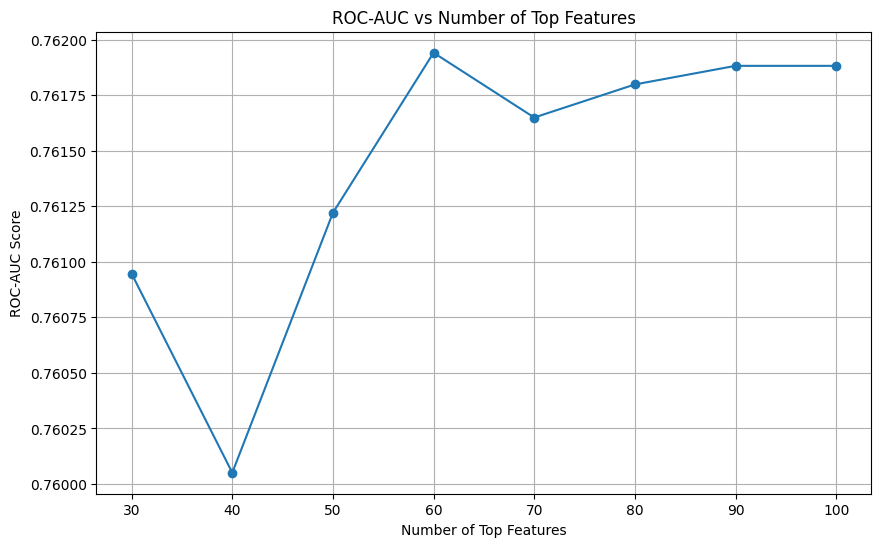

In [34]:
# Plotting the results
results_df = pd.DataFrame(results, columns=['Num_Features', 'ROC_AUC'])
plt.figure(figsize=(10, 6))
plt.plot(results_df['Num_Features'], results_df['ROC_AUC'], marker='o')
plt.title('ROC-AUC vs Number of Top Features')
plt.xlabel('Number of Top Features')
plt.ylabel('ROC-AUC Score')
plt.grid(True)
plt.show()

According to this plot, performance clearly peaks at 60 features.

Hence, let's save the top 60 features for future reference

In [35]:
with open('../config/top_features.json', 'w') as f:
    json.dump(selected_features, f)

print(f"Top {optimal_features_count} features saved successfully.")

Top 60 features saved successfully.
